In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from glob import glob
from pprint import pprint
from math import sqrt
import os


pd.options.display.float_format = '{:.6f}'.format


## Config Session
### This session contains static information essential to the code

In [2]:
PATH_FILE = 'data/acc'
PATH_FILE_METRICS_OUTPUT = 'data/metrics_accuracy'
PATH_FILE_AREA = 'data/area/area-paper-frontiers.xlsx'

SELECTOR = [
    'NEW_PROB', 'year', 'border', 'PESO_AMOS','POINTEDITE',
    'AMOSTRAS','REINSP','NEW_PROB','ADJ_FACTOR','PESO_VOT'
]

REMAP_CLASSES = {
    6: 3
}

# 0 - no, 1 - yes
ACCEPT_BORDER = 0

YEARS = list(range(1985, 2022, 1))

CLASSES = {
    3: 'Forest',
    4: 'Shrubland',
    6: 'Flooded Forest',
    11: 'Wetland',
    12: 'Natural Grassland',
    15: 'Pastureland',
    18: 'Cropland',
    22: 'Bareland and Impervious',
    29: 'Rock Outcrop',
    33: 'Water'
}


In [3]:
f'{1.9983e-9:.15f}'

'0.000000001998300'

## Input Data
### This session we load the input data, files to perform calculations

In [4]:
df_samples = pd.concat([pd.read_csv(x) for x in glob(PATH_FILE + '/*')])
df_samples = df_samples[[
    'reference', 'classification', 'year', 'border',
    'BIOMA', 'AMOSTRAS']]

# filter samples
df_samples = df_samples.loc[df_samples['reference'].isin(CLASSES.keys())]
df_samples = df_samples.query(f'border == {ACCEPT_BORDER}')
df_samples = df_samples.query('AMOSTRAS != "Treinamento" & BIOMA == "Amazônia"')

df_areas = pd.read_excel(PATH_FILE_AREA)

# df_samples['reference'].drop_duplicates()

## Helper Functions
### Auxiliar functions

In [5]:
def calculate_metrics(confusion_matrix, classes):

    accuracy_user = {}
    accuracy_producer = {}
    precision = {}
    recall = {}
    f1_score = {}
    comission_error = {}
    omission_error = {}




    for class_name in classes.values():
        class_index = df.index.get_loc(class_name)

        true_positive = confusion_matrix.iloc[class_index, class_index]
        false_positive = confusion_matrix.iloc[class_index, :].sum() - true_positive
        false_negative = confusion_matrix.iloc[:, class_index].sum() - true_positive

        #
        comission_error[class_name] = false_positive / (true_positive + false_positive)\
            if (true_positive + false_positive) != 0 else 0
        
        #
        omission_error[class_name] = false_negative / (true_positive + false_negative)\
            if (true_positive + false_negative) != 0 else 0


        #
        accuracy_user[class_name] = true_positive / (true_positive + false_positive) \
            if (true_positive + false_positive) != 0 else 0
        
        #
        accuracy_producer[class_name] = true_positive / (true_positive + false_negative)\
            if (true_positive + false_negative) != 0 else 0
        

        precision[class_name] = true_positive / (true_positive + false_positive) \
            if (true_positive + false_positive) != 0 else 0
        
        recall[class_name] = true_positive / (true_positive + false_negative) \
            if (true_positive + false_negative) != 0 else 0
        
        f1_score[class_name] = 2 * (precision[class_name] * recall[class_name]) / (precision[class_name] + recall[class_name]) \
            if (precision[class_name] + recall[class_name]) != 0 else 0

    return accuracy_user, accuracy_producer, precision, recall, f1_score, comission_error, omission_error



## Get Metrics of Accuracy
### overall acc, producer, user, precision, recall, f1-score

In [6]:

overall_acc = []
table_area = []
n_sp = []

for year in YEARS:

    # output names
    name_cm_percentage = f'confusion_matrix_percentage_{year}.csv'
    name_cm = f'confusion_matrix_{year}.csv'
    name_metrics = f'metrics_{year}.csv'


    df_samples_year = df_samples.query(f'year == {year}')



    # get reference and predicted lists
    y_true = np.array(df_samples_year[['reference']].values).flatten()
    y_pred = np.array(df_samples_year[['classification']].values).flatten()



    # get confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    # matrix_transposed = matrix.transpose()



    # get total samples of each class
    total_samples = [sum(row) for row in matrix]
    total_samples_cls = list(zip(CLASSES.values(), total_samples))



    # calculate percentages for each element in the confusion matrix
    percentage_data = [[value / total_samples[i] * 100 for value in row] for i, row in enumerate(matrix)]



    # create DataFrame with data percentage
    df_percentage = pd.DataFrame(
        percentage_data, 
        columns=[CLASSES[key] for key in CLASSES.keys()], index=[CLASSES[key] for key in CLASSES.keys()]
    )


    # create DataFrame with data keys
    df = pd.DataFrame(
        matrix, 
        columns=[CLASSES[key] for key in CLASSES.keys()], index=[CLASSES[key] for key in CLASSES.keys()]
    )


    accuracy_user, accuracy_producer, \
    precision, recall, f1_score, comission_error, omission_error = calculate_metrics(df, CLASSES)



    # now get overall accuracy
    total_correct = sum([matrix[i][i] for i in range(len(matrix))])
    total_samples = np.sum(matrix)
    global_accuracy = total_correct / total_samples


    overall_acc.append(global_accuracy)

    
    # add accuracy and metrics columns to the DataFrame
    df_percentage['Accuracy User'] = [round(accuracy_user[class_name], 2) for class_name in df.index]
    df_percentage['Accuracy Producer'] = [round(accuracy_producer[class_name], 2) for class_name in df.index]
    df_percentage['Precision'] = [round(precision[class_name], 2) for class_name in df.index]
    df_percentage['Recall'] = [round(recall[class_name], 2) for class_name in df.index]
    df_percentage['F1-Score'] = [round(f1_score[class_name], 2) for class_name in df.index]
    df_percentage['Comission Error'] = [round(comission_error[class_name], 2) for class_name in df.index]
    df_percentage['Omission Error'] = [round(omission_error[class_name], 2) for class_name in df.index]

    df_percentage = df_percentage.round(2)


    # add sum of collums and rows
    df.loc['Total'] = [df.loc[CLASSES.values(), cls_name].sum() for cls_name in CLASSES.values()]
    df['Total'] = [df.loc[cls_name].sum() for cls_name in CLASSES.values()] + [df.loc['Total'].sum()]


    # get n samples
    # n_samples = df.loc[CLASSES.values()][['Total']].reset_index()
    # n_samples['year'] = year
    # n_sp.append(n_samples)

    # save table
    # df.to_csv(PATH_FILE_METRICS_OUTPUT + '/' + name_cm)
    


    # calculate adjusted area
    # 1. get proportion area
    df_proportion_area = df_areas.query(f'year == {year}')
    df_proportion_area = pd.melt(
        df_proportion_area, id_vars=['year'], value_vars=CLASSES.values()
    )
    
    df_proportion_area['value_p'] = df_proportion_area['value'].div(df_proportion_area['value'].sum())

    df_proportion_area = df_proportion_area.set_index('variable')
    df_proportion_area.columns = ['year', 'area', 'area_p']




    # 2. get estimated proportion area
    # (tp / total) * proportion    
    rows_estimated = []
    for cls_ in CLASSES.values():
        rows_estimated_ = []
        for cls__ in CLASSES.values():
            r = (df.loc[cls_, cls__] / df.loc[cls_, 'Total']) * df_proportion_area.loc[cls_, 'area_p']
            rows_estimated_.append(r)
        rows_estimated.append(rows_estimated_)

    df_estimated = pd.DataFrame(
        rows_estimated, 
        columns=[CLASSES[key] for key in CLASSES.keys()], index=[CLASSES[key] for key in CLASSES.keys()]
    )




    # 2.1  get total estimated proportion area
    # sum_prop_class / total_area_map
    df_estimated.loc['Total'] = [df_estimated.loc[CLASSES.values(), cls_name].sum() for cls_name in CLASSES.values()]
    df_estimated['Total'] = [df_estimated.loc[cls_name].sum() for cls_name in CLASSES.values()] + [df_estimated.loc['Total'].sum()]




    # 3.0 get pre adjusted area
    df_estimated.loc['Area Adjusted'] = [df_estimated.loc['Total', x] * df_proportion_area['area'].sum() for x in CLASSES.values()] + ['']




    # 4.0 get deviations
    rows_deviations = []
    for cls_ in CLASSES.values():
        rows_deviations_ = []
        for cls__ in CLASSES.values():
            # (ij * total_ij) - (ij ** 2)   | total_px_i
            # (ij_estimated * total_ij_estimated) - (total_ij_px)
            ij = df_estimated.loc[cls_, cls__]
            ij_total = df_estimated.loc[cls_, 'Total']
            ij_px_total = df.loc[cls_, 'Total']

            r = ((ij * ij_total) - (ij ** 2)) / (ij_px_total - 1)

            rows_deviations_.append(r)
        rows_deviations.append(rows_deviations_)

    df_deviations = pd.DataFrame(
        rows_deviations, 
        columns=[CLASSES[key] for key in CLASSES.keys()], index=[CLASSES[key] for key in CLASSES.keys()]
    )

    df_deviations.loc['Total'] = [df_deviations.loc[CLASSES.values(), cls_name].sum() for cls_name in CLASSES.values()]
    df_deviations.loc['S(Â)'] = [sqrt(df_deviations.loc['Total', cls_name]) for cls_name in CLASSES.values()]
    df_deviations.loc['S(Â) ha'] = [df_deviations.loc['S(Â)', cls_name] * df_proportion_area['area'].sum() for cls_name in CLASSES.values()]
    df_deviations.loc['CI (95%)'] = [1.96 * df_deviations.loc['S(Â) ha', cls_name] for cls_name in CLASSES.values()]



    # 5. get final table adjusted
    df_table_area_adjusted = df_proportion_area
    df_table_area_adjusted['area_adjusted'] = [df_estimated.loc['Area Adjusted', cls_name] for cls_name in CLASSES.values()]
    df_table_area_adjusted['ci_95'] = [df_deviations.loc['CI (95%)', cls_name] for cls_name in CLASSES.values()]
    df_table_area_adjusted['inferior_limit'] = df_table_area_adjusted['area_adjusted'].sub(df_table_area_adjusted['ci_95'])
    df_table_area_adjusted['superior_limit'] = df_table_area_adjusted['area_adjusted'].add(df_table_area_adjusted['ci_95'])
    df_table_area_adjusted['area_diff'] = df_table_area_adjusted['area_adjusted'].sub(df_table_area_adjusted['area'])
    df_table_area_adjusted = df_table_area_adjusted.reset_index()

    table_area.append(df_table_area_adjusted)





    # set metrics to calculate adjusted area
    df['Accuracy User'] = [round(accuracy_user[class_name], 2) for class_name in CLASSES.values()] + ['']
    df.loc['Accuracy Producer'] = [round(accuracy_producer[class_name], 2) for class_name in CLASSES.values()] + ['', '']
    
    df['Comission Error'] = [round(comission_error[class_name], 2) for class_name in CLASSES.values()] + ['', '']
    df.loc['Omission Error'] = [round(omission_error[class_name], 2) for class_name in CLASSES.values()] + ['', '', '']




    #  save tables
    # df_percentage[CLASSES.values()].to_csv(PATH_FILE_METRICS_OUTPUT + '/' + name_cm_percentage)
    # df.to_csv(PATH_FILE_METRICS_OUTPUT + '/' + name_cm)
    # df_percentage[[
    #     'Accuracy User',
    #     'Accuracy Producer',
    #     'Precision',
    #     'Recall',
    #     'F1-Score',
    #     'Comission Error',
    #     'Omission Error'
    # ]].to_csv(PATH_FILE_METRICS_OUTPUT + '/' + name_metrics)

df_overall_acc = pd.DataFrame({'year': YEARS, 'acc': overall_acc})
df_table_area = pd.concat(table_area)

df_table_area.to_csv('data/metrics_accuracy/table_area_adjusted.csv')
# df_overall_acc.to_csv('data/metrics_accuracy/overall_accuracy.csv')


In [7]:
df

,Forest,Shrubland,Flooded Forest,Wetland,Natural Grassland,Pastureland,Cropland,Bareland and Impervious,Rock Outcrop,Water,Total,Accuracy User,Comission Error
Forest,15358.000000,21.000000,645.000000,31.000000,63.000000,221.000000,3.000000,0,5.000000,3.000000,16350,0.940000,0.060000
Shrubland,46.000000,35.000000,15.000000,50.000000,103.000000,16.000000,0.000000,0,12.000000,0.000000,277,0.130000,0.870000
Flooded Forest,152.000000,3.000000,162.000000,47.000000,13.000000,3.000000,0.000000,0,0.000000,8.000000,388,0.420000,0.580000
Wetland,7.000000,9.000000,23.000000,159.000000,38.000000,3.000000,0.000000,0,0.000000,14.000000,253,0.630000,0.370000
Natural Grassland,11.000000,7.000000,16.000000,173.000000,420.000000,8.000000,0.000000,0,5.000000,0.000000,640,0.660000,0.340000
Pastureland,277.000000,24.000000,19.000000,20.000000,94.000000,3015.000000,45.000000,0,3.000000,0.000000,3497,0.860000,0.140000
Cropland,29.000000,1.000000,0.000000,3.000000,17.000000,166.000000,337.000000,0,0.000000,0.000000,553,0.610000,0.390000
Bareland and Impervious,12.000000,2.000000,2.000000,5.000000,20.000000,34.000000,2.000000,0,0.000000,3.000000,80,0.000000,1.000000
Rock Outcrop,15.000000,1.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0,6.000000,1.000000,34,0.180000,0.820000
Water,14.000000,1.000000,5.000000,13.000000,5.000000,3.000000,0.000000,0,0.000000,351.000000,392,0.900000,0.100000


In [8]:
df_percentage[CLASSES.values()]

,Forest,Shrubland,Flooded Forest,Wetland,Natural Grassland,Pastureland,Cropland,Bareland and Impervious,Rock Outcrop,Water
Forest,93.930000,0.130000,3.940000,0.190000,0.390000,1.350000,0.020000,0.000000,0.030000,0.020000
Shrubland,16.610000,12.640000,5.420000,18.050000,37.180000,5.780000,0.000000,0.000000,4.330000,0.000000
Flooded Forest,39.180000,0.770000,41.750000,12.110000,3.350000,0.770000,0.000000,0.000000,0.000000,2.060000
Wetland,2.770000,3.560000,9.090000,62.850000,15.020000,1.190000,0.000000,0.000000,0.000000,5.530000
Natural Grassland,1.720000,1.090000,2.500000,27.030000,65.620000,1.250000,0.000000,0.000000,0.780000,0.000000
Pastureland,7.920000,0.690000,0.540000,0.570000,2.690000,86.220000,1.290000,0.000000,0.090000,0.000000
Cropland,5.240000,0.180000,0.000000,0.540000,3.070000,30.020000,60.940000,0.000000,0.000000,0.000000
Bareland and Impervious,15.000000,2.500000,2.500000,6.250000,25.000000,42.500000,2.500000,0.000000,0.000000,3.750000
Rock Outcrop,44.120000,2.940000,0.000000,0.000000,32.350000,0.000000,0.000000,0.000000,17.650000,2.940000
Water,3.570000,0.260000,1.280000,3.320000,1.280000,0.770000,0.000000,0.000000,0.000000,89.540000


In [9]:
df_percentage[[
    'Accuracy User',
    'Accuracy Producer',
    'Precision',
    'Recall',
    'F1-Score',
    'Comission Error',
    'Omission Error'
]]

,Accuracy User,Accuracy Producer,Precision,Recall,F1-Score,Comission Error,Omission Error
Forest,0.940000,0.960000,0.940000,0.960000,0.950000,0.060000,0.040000
Shrubland,0.130000,0.340000,0.130000,0.340000,0.180000,0.870000,0.660000
Flooded Forest,0.420000,0.180000,0.420000,0.180000,0.250000,0.580000,0.820000
Wetland,0.630000,0.320000,0.630000,0.320000,0.420000,0.370000,0.680000
Natural Grassland,0.660000,0.540000,0.660000,0.540000,0.590000,0.340000,0.460000
Pastureland,0.860000,0.870000,0.860000,0.870000,0.870000,0.140000,0.130000
Cropland,0.610000,0.870000,0.610000,0.870000,0.720000,0.390000,0.130000
Bareland and Impervious,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Rock Outcrop,0.180000,0.190000,0.180000,0.190000,0.180000,0.820000,0.810000
Water,0.900000,0.920000,0.900000,0.920000,0.910000,0.100000,0.080000


## Display Heatmap for confusion matrix

<Axes: >

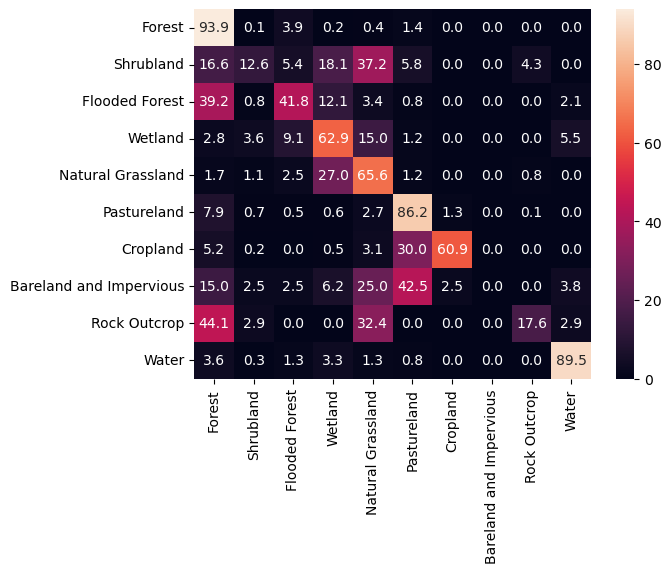

In [10]:
import seaborn as sns
df_heat = df_percentage.loc[~df_percentage.index.isin(CLASSES.keys())]

sns.heatmap(df_heat[CLASSES.values()], annot=True, fmt=".1f")